In [1]:
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import open3d as o3d
from ultralytics import YOLO
import shutil
from projection import yolo_txt

In [2]:

binary = f'D:\lidar\point\\000008\point_seg\pcd_nongrond_seg.pcd'
pcd = o3d.io.read_point_cloud(binary)
original_colors = np.asarray(pcd.colors)
original_pts = np.asarray(pcd.points)

# print("Color value range:", np.min(original_colors), np.max(original_colors))

# 检查原始点云数据
print(f"Original point cloud shape: {original_pts.shape}")

# 筛选有效点云
valid_indices = original_pts[:, 0] > 0
valid_pts = original_pts[valid_indices]
valid_colors = original_colors[valid_indices]

print(f"Valid point cloud shape: {valid_pts.shape}")

# 创建筛选后的点云
pcd_selected = o3d.geometry.PointCloud()
pcd_selected.points = o3d.utility.Vector3dVector(valid_pts)
pcd_selected.colors = o3d.utility.Vector3dVector(valid_colors)

# 可视化带颜色的点云
o3d.visualization.draw_geometries([pcd_selected])

Original point cloud shape: (6961, 3)
Valid point cloud shape: (6961, 3)


![alt text](image.png)

6961


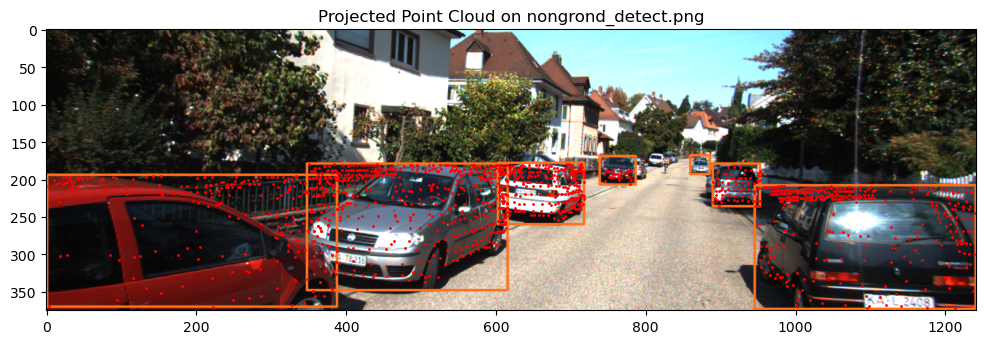

In [3]:
path = 'D:\lidar\point'
name = 'nongrond'
# yolo_txt(name,path)
# 读取原始点云数据
# name = '000008'
# binary = f'D:\lidar\point\\000008\\000008.bin'
# scan = np.fromfile(binary, dtype=np.float32).reshape((-1, 4))
# original_pts = scan[:, :3]  # 提取 (x, y, z) 坐标
# # original_pts = np.array(original_pts)[original_pts[:, 0] > 0]
# pcd_selected = o3d.geometry.PointCloud()
# pcd_selected.points = o3d.utility.Vector3dVector(original_pts)

# 显示筛选后的点云
o3d.visualization.draw_geometries([pcd_selected])
print(len(pcd_selected.points))

# 读取相机参数
with open(f'D:\lidar\point\\000008\\000008.txt', 'r') as f:
    calib = f.readlines()

# P2 (3 x 4) for left eye
P2 = np.array([float(x) for x in calib[2].strip('\n').split(' ')[1:]]).reshape(3, 4)
R0_rect = np.array([float(x) for x in calib[4].strip('\n').split(' ')[1:]]).reshape(3, 3)
R0_rect = np.insert(R0_rect, 3, values=[0, 0, 0], axis=0)
R0_rect = np.insert(R0_rect, 3, values=[0, 0, 0, 1], axis=1)
Tr_velo_to_cam = np.array([float(x) for x in calib[5].strip('\n').split(' ')[1:]]).reshape(3, 4)
Tr_velo_to_cam = np.insert(Tr_velo_to_cam, 3, values=[0, 0, 0, 1], axis=0)

# 读取图像尺寸
img_path = f'D:\lidar\point\\000008\save\\000008.png'
img = mpimg.imread(img_path)
IMG_H, IMG_W, _ = img.shape

# 读取检测框信息
with open(f'D:\lidar\point\\000008\save\labels\\000008.txt', 'r') as f:
    detections = [line.strip().split() for line in f.readlines()]

detections = [[float(x) for x in det] for det in detections]

# 投影点云到图像
velo = np.insert(original_pts, 3, 1, axis=1).T
cam = P2.dot(R0_rect.dot(Tr_velo_to_cam.dot(velo)))
cam = np.delete(cam, np.where(cam[2, :] < 0), axis=1)
cam[:2] /= cam[2, :]

# 获取落在检测框中的投影点云索引
projected_indices = []
for det in detections:
    _, u_center, v_center, width, height, a = det
    u_min = (u_center - width / 2) * IMG_W
    u_max = (u_center + width / 2) * IMG_W
    v_min = (v_center - height / 2) * IMG_H
    v_max = (v_center + height / 2) * IMG_H
    u, v = cam[:2]
    u_in = np.logical_and(u >= u_min, u <= u_max)
    v_in = np.logical_and(v >= v_min, v <= v_max)
    in_box = np.logical_and(u_in, v_in)
    projected_indices.append(np.where(in_box)[0])
    # break

# 合并所有投影点云索引
projected_indices = np.concatenate(projected_indices)

# 提取落在检测框中的投影点云数据
u, v, z = cam
projected_pts = np.stack([u[projected_indices], v[projected_indices]], axis=1)
# projected_pts = np.stack([u, v], axis=1)

# 显示投影点云和原始图像
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.scatter(projected_pts[:, 0], projected_pts[:, 1], c='r', s=1)
plt.title(f'Projected Point Cloud on {name}_detect.png')
# plt.savefig(f'{path}/000008_projection_detect_filter.png',bbox_inches='tight')
plt.show()


In [4]:
bboxes = []
i = 0
for det in detections:
    _, u_center, v_center, width, height, a = det
    left_top = ((u_center - width / 2) * IMG_W, (v_center - height / 2) * IMG_H)
    right_top = ((u_center + width / 2) * IMG_W, (v_center - height / 2) * IMG_H)
    left_bottom = ((u_center - width / 2) * IMG_W, (v_center + height / 2) * IMG_H)
    right_bottom = ((u_center + width / 2) * IMG_W, (v_center + height / 2) * IMG_H)
    box = tuple([left_top, right_bottom])
    i += 1
    bboxes.append(box)
print(bboxes[0])
print(bboxes[0][0])


((1.346328000000002, 194.8828125), (388.269072, 370.9696875))
(1.346328000000002, 194.8828125)


In [5]:
calib_path = 'D:\lidar\point\\000008\\000008.txt'


def get_calib(calib_path):
    with open(calib_path, 'r') as f:
        calib = f.readlines()

    P2 = np.array([float(x) for x in calib[2].strip('\n').split(' ')[1:]]).reshape(3, 4)
    K = np.array(P2[:12]).reshape(3, 4)[:3, :3]

    # 从字符串解析出从激光雷达到相机的变换矩阵
    Tr_velo_to_cam = np.array([float(x) for x in calib[5].strip('\n').split(' ')[1:]]).reshape(3, 4)
    Tr_velo_to_cam = np.insert(Tr_velo_to_cam, 3, values=[0, 0, 0, 1], axis=0)
    Tr = np.array([Tr_velo_to_cam[0, 3], Tr_velo_to_cam[1, 3], Tr_velo_to_cam[2, 3]])

    R0_rect = np.array([float(x) for x in calib[4].strip('\n').split(' ')[1:]]).reshape(3, 3)
    return P2, K, Tr_velo_to_cam, Tr, R0_rect


P2, K, Tr_velo_to_cam, Tr, R0_rect = get_calib(calib_path)
print('P2.shape:', P2.shape)
print('K.shape:', K.shape)
print('Tr_velo_to_cam.shape:', Tr_velo_to_cam.shape)
print('tr.shape:', Tr.shape)
print('R0.shape:', R0_rect.shape)
print('P2:\n', P2)
print('Tr_velo_to_cam:\n', Tr_velo_to_cam)
print('Tr:\n', Tr)
print('R0_rect:\n', R0_rect)

P2.shape: (3, 4)
K.shape: (3, 3)
Tr_velo_to_cam.shape: (4, 4)
tr.shape: (3,)
R0.shape: (3, 3)
P2:
 [[     721.54           0      609.56      44.857]
 [          0      721.54      172.85     0.21638]
 [          0           0           1   0.0027459]]
Tr_velo_to_cam:
 [[  0.0075337    -0.99997  -0.0006166  -0.0040698]
 [   0.014802  0.00072807    -0.99989   -0.076316]
 [    0.99986   0.0075238    0.014808    -0.27178]
 [          0           0           0           1]]
Tr:
 [ -0.0040698   -0.076316    -0.27178]
R0_rect:
 [[    0.99992   0.0098378   -0.007445]
 [ -0.0098698     0.99994  -0.0042785]
 [  0.0074025   0.0043516     0.99996]]


In [6]:
import cv2


def drawLabel(bboxes, img):  # 定义绘制函数
    for item in bboxes:
        a = tuple(map(int, item[0]))  # 将坐标转换为整数并转换为元组
        b = tuple(map(int, item[1]))  # 将坐标转换为整数并转换为元组

        #  rectangle函数（图片，长方形框左上角坐标, 长方形框右下角坐标， 字体颜色，字体粗细）
        cv2.rectangle(img, a, b, (0, 0, 255), 2)  # 绘制矩形框
    cv2.imshow('image', img)
    cv2.waitKey(0)  # 等待键盘事件以关闭窗口
    cv2.destroyAllWindows()  # 关闭窗口


bboxes = []
img = cv2.imread('D:\lidar\point\\000008\\000008.png')
# 假设detections是一个已定义的变量，包含检测结果
# detections = [(score, u_center, v_center, width, height, angle), ...]
print(len(detections))
i = 0
for det in detections:
    i += 1
    _, u_center, v_center, width, height, _ = det
    left_top = ((u_center - width / 2) * IMG_W, (v_center - height / 2) * IMG_H)
    # right_top = [(u_center + width / 2) * IMG_W, (v_center - height / 2) * IMG_H]
    # left_bottom = ((u_center - width / 2) * IMG_W, (v_center + height / 2) * IMG_H)
    right_bottom = ((u_center + width / 2) * IMG_W, (v_center + height / 2) * IMG_H)
    box = ([left_top, right_bottom])
    if i == 3:
        drawLabel([box], img)
    bboxes.append(box)
    # break

# 假设img是一个已读取的图像

drawLabel(bboxes, img)


7


In [12]:
def pixel_to_normalized(x, y, cx, cy, fx, fy):
    x_norm = (x - cx) / fx
    y_norm = (y - cy) / fy
    return x_norm, y_norm


def normalized_to_camera(x_norm, y_norm, Z):
    X = x_norm * Z
    Y = y_norm * Z
    return X, Y, Z


def camera_to_lidar(X, Y, Z, Tr_velo_to_cam, R0_rect):
    camera_coords = np.array([X, Y, Z, 1.0]).reshape(4, 1)
    R0_rect_4x4 = np.eye(4)
    R0_rect_4x4[:3, :3] = R0_rect

    # 首先应用R0_rect
    rectified_coords = R0_rect_4x4 @ camera_coords
    # 然后应用Tr_velo_to_cam的逆
    transform_matrix_inv = np.linalg.inv(Tr_velo_to_cam)
    lidar_coords = transform_matrix_inv @ rectified_coords
    return lidar_coords.flatten()[:3]


def point_in_frustum(point, frustum_planes):
    for plane in frustum_planes:
        if np.dot(plane[:3], point) + plane[3] > 0:
            return False
    return True


# 计算平面方程：Ax + By + Cz + D = 0
def compute_plane_equation(p1, p2, p3):
    normal = np.cross(p2 - p1, p3 - p1)
    normal = normal / np.linalg.norm(normal)
    D = -np.dot(normal, p1)
    return np.append(normal, D)


def get_calib(calib_path):
    with open(calib_path, 'r') as f:
        calib = f.readlines()

    P2 = np.array([float(x) for x in calib[2].strip('\n').split(' ')[1:]]).reshape(3, 4)
    K = np.array(P2[:12]).reshape(3, 4)[:3, :3]

    # 从字符串解析出从激光雷达到相机的变换矩阵
    Tr_velo_to_cam = np.array([float(x) for x in calib[5].strip('\n').split(' ')[1:]]).reshape(3, 4)
    Tr_velo_to_cam = np.insert(Tr_velo_to_cam, 3, values=[0, 0, 0, 1], axis=0)
    Tr = np.array([Tr_velo_to_cam[0, 3], Tr_velo_to_cam[1, 3], Tr_velo_to_cam[2, 3]])

    R0_rect = np.array([float(x) for x in calib[4].strip('\n').split(' ')[1:]]).reshape(3, 3)
    return P2, K, Tr_velo_to_cam, Tr, R0_rect


calib_path = 'D:\lidar\point\\000008\\000008.txt'

P2, K, Tr_velo_to_cam, Tr, R0_rect = get_calib(calib_path)

with open(f'D:\lidar\point\\000008\save\labels\\000008.txt', 'r') as f:
    detections = [line.strip().split() for line in f.readlines()]

detections = [[float(x) for x in det] for det in detections]

# 相机内参
fx, fy = P2[0, 0], P2[1, 1]
cx, cy = P2[0, 2], P2[1, 2]

# 远近平面
Z_near, Z_far = 1, 10

# 用于存储所有视锥线条的列表
all_lines = []
all_frustum_points = []
all_planes = []

i = 0
for det in detections:
    i += 1
    _, u_center, v_center, width, height, _ = det
    left_top = ((u_center - width / 2) * IMG_W, (v_center - height / 2) * IMG_H)
    right_top = ((u_center + width / 2) * IMG_W, (v_center - height / 2) * IMG_H)
    left_bottom = ((u_center - width / 2) * IMG_W, (v_center + height / 2) * IMG_H)
    right_bottom = ((u_center + width / 2) * IMG_W, (v_center + height / 2) * IMG_H)
    bbox = [left_top, right_top, left_bottom, right_bottom]

    frustum_points = []
    for (x, y) in bbox:
        x_norm, y_norm = pixel_to_normalized(x, y, cx, cy, fx, fy)
        for Z in [Z_near, Z_far]:
            X_cam, Y_cam, Z_cam = normalized_to_camera(x_norm, y_norm, Z)
            X_lidar, Y_lidar, Z_lidar = camera_to_lidar(X_cam, Y_cam, Z_cam, Tr_velo_to_cam, R0_rect)
            frustum_points.append(np.array([X_lidar, Y_lidar, Z_lidar]))

    frustum_points = np.array(frustum_points)
    base_index = len(all_frustum_points)
    all_frustum_points.extend(frustum_points)

    # 计算视锥的平面
    frustum_planes = []
    # 左平面
    frustum_planes.append(compute_plane_equation(frustum_points[0], frustum_points[2], frustum_points[4]))
    # 右平面
    frustum_planes.append(compute_plane_equation(frustum_points[1], frustum_points[3], frustum_points[5]))
    # 上平面
    frustum_planes.append(compute_plane_equation(frustum_points[0], frustum_points[1], frustum_points[4]))
    # 下平面
    frustum_planes.append(compute_plane_equation(frustum_points[2], frustum_points[3], frustum_points[6]))
    # 近平面
    frustum_planes.append(compute_plane_equation(frustum_points[0], frustum_points[1], frustum_points[2]))
    # 远平面
    frustum_planes.append(compute_plane_equation(frustum_points[4], frustum_points[5], frustum_points[6]))

    all_planes.append(frustum_planes)

    # 绘制视锥
    lines = [
        [0, 1], [1, 3], [3, 2], [2, 0],  # 近平面
        [4, 5], [5, 7], [7, 6], [6, 4],  # 远平面
        [0, 4], [1, 5], [2, 6], [3, 7]  # 连接线
    ]
    if i ==3 :
        all_lines.extend([[base_index + line[0], base_index + line[1]] for line in lines])
    # break

# 创建LineSet对象
line_set = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(np.vstack(all_frustum_points)),
    lines=o3d.utility.Vector2iVector(all_lines)
)
colors = [[1, 0, 0] for _ in range(len(all_lines))]
line_set.colors = o3d.utility.Vector3dVector(colors)
pcd_selected.colors = o3d.utility.Vector3dVector(valid_colors)
geometry_list = [pcd_selected, line_set]
# 显示点云和视锥
o3d.visualization.draw_geometries(geometry_list)
print(frustum_points)

[[     1.2776    -0.33505   -0.043531]
 [      10.32     -3.3328     0.21527]
 [     1.2782    -0.37097   -0.043194]
 [     10.326      -3.692     0.21863]
 [     1.2783    -0.33537   -0.078883]
 [     10.327      -3.336    -0.13825]
 [     1.2788    -0.37129   -0.078546]
 [     10.332     -3.6952    -0.13489]]


In [10]:
pcd_selected_filtered = o3d.geometry.PointCloud()
filtered_pts = original_pts[projected_indices]
print(len(filtered_pts))
pcd_selected_filtered.points = o3d.utility.Vector3dVector(filtered_pts)
o3d.visualization.draw_geometries([pcd_selected_filtered])

1461


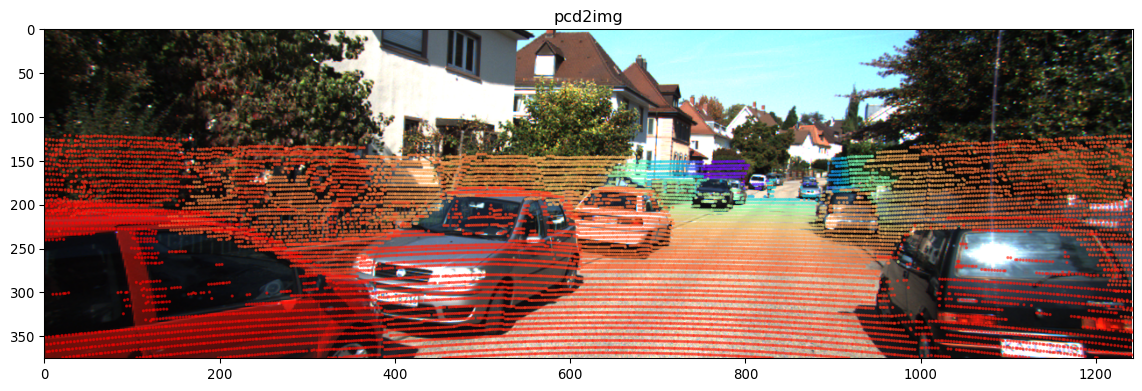

In [27]:
path = 'D:\lidar\point'
name = 'nongrond'
binary = f'D:\lidar\point\\000008\\000008.bin'
scan = np.fromfile(binary, dtype=np.float32).reshape((-1, 4))
original_pts = scan[:, :3]  # 提取 (x, y, z) 坐标
reflectance = scan[:, 3]  # 提取反射强度信息

# 读取相机参数
with open(f'D:\lidar\point\\000008\\000008.txt', 'r') as f:
    calib = f.readlines()

# P2 (3 x 4) for left eye
P2 = np.array([float(x) for x in calib[2].strip('\n').split(' ')[1:]]).reshape(3, 4)
R0_rect = np.array([float(x) for x in calib[4].strip('\n').split(' ')[1:]]).reshape(3, 3)
R0_rect = np.insert(R0_rect, 3, values=[0, 0, 0], axis=0)
R0_rect = np.insert(R0_rect, 3, values=[0, 0, 0, 1], axis=1)
Tr_velo_to_cam = np.array([float(x) for x in calib[5].strip('\n').split(' ')[1:]]).reshape(3, 4)
Tr_velo_to_cam = np.insert(Tr_velo_to_cam, 3, values=[0, 0, 0, 1], axis=0)

# 读取图像尺寸
img_path = f'D:\lidar\point\\000008\\000008.png'
img = mpimg.imread(img_path)
IMG_H, IMG_W, _ = img.shape

# 投影点云到图像
velo = np.insert(original_pts, 3, 1, axis=1).T
cam = P2.dot(R0_rect.dot(Tr_velo_to_cam.dot(velo)))
cam = np.delete(cam, np.where(cam[2, :] < 0), axis=1)
cam[:2] /= cam[2, :]

plt.figure(figsize=(12, 5), dpi=96, tight_layout=True)
# restrict canvas in range
plt.axis([0, IMG_W, IMG_H, 0])
plt.imshow(img)
# filter point out of canvas
u, v, z = cam
u_out = np.logical_or(u < 0, u > IMG_W)
v_out = np.logical_or(v < 0, v > IMG_H)
outlier = np.logical_or(u_out, v_out)
cam = np.delete(cam, np.where(outlier), axis=1)
# generate color map from depth
u, v, z = cam
plt.scatter([u], [v], c=[z], cmap='rainbow_r', alpha=0.5, s=2)
plt.title('pcd2img')
plt.show()


In [6]:
print(projected_pts.shape)
print(original_pts.shape)
pcd_orin = o3d.geometry.PointCloud()
pcd_orin.points = o3d.utility.Vector3dVector(original_pts)

box_pts = original_pts[projected_indices]
pcd_filter = o3d.geometry.PointCloud()
pcd_filter.points = o3d.utility.Vector3dVector(box_pts)

# 创建一个新的点云对象，其中仅包含不在pcd_filter中的点
pcd_orin_filtered = pcd_orin.select_by_index([i for i in range(len(original_pts)) if i not in projected_indices])

# 设置颜色
pcd_orin.paint_uniform_color([1, 0, 0])  # 原始点云为红色
pcd_filter.paint_uniform_color([0, 0, 1])  # 投影后的点云为蓝色
pcd_orin_filtered.paint_uniform_color([1, 0, 0])  # 过滤后的原始点云为红色

# 显示点云
o3d.visualization.draw_geometries([pcd_orin_filtered, pcd_filter])

(8975, 2)
(60391, 3)


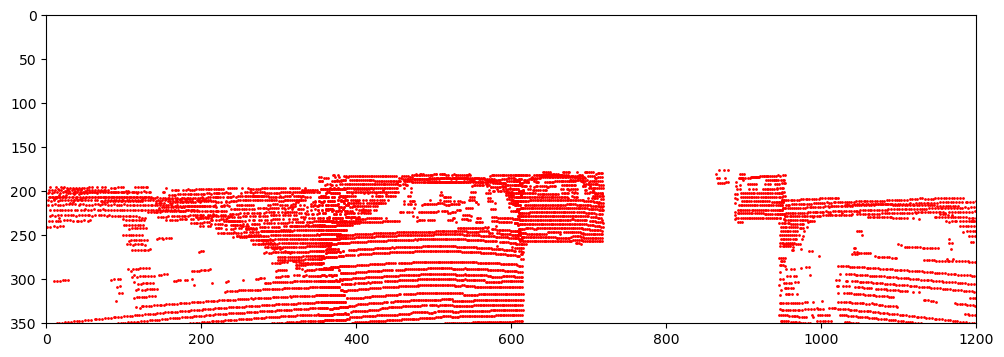

In [80]:
plt.figure(figsize=(12, 4))
plt.scatter(projected_pts[:, 0], projected_pts[:, 1], c='r', s=1)
plt.axis([0, 1200, 0, 350])
plt.gca().invert_yaxis()

In [74]:
print(projected_pts)

[[     388.36      196.02]
 [     384.58      196.02]
 [     376.95      195.98]
 ...
 [     871.59      190.06]
 [        869      190.07]
 [     866.44      190.09]]


In [98]:
box_pts = original_pts[projected_indices]
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(box_pts)
o3d.visualization.draw_geometries([pcd])
print(len(pcd.points))

8838


113 482 309 482


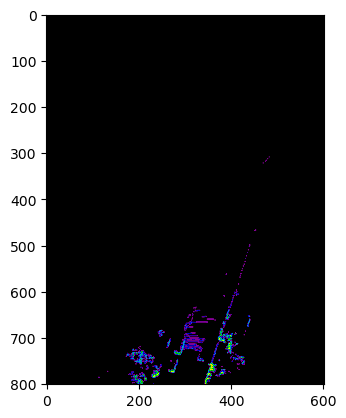

In [100]:
from PIL import Image

pointcloud = box_pts
side_range = (-30, 30)  # 左右距离
fwd_range = (0, 80)  # 后前距离

x_points = pointcloud[:, 0]
y_points = pointcloud[:, 1]
z_points = pointcloud[:, 2]

# 获得区域内的点
f_filt = np.logical_and(x_points > fwd_range[0], x_points < fwd_range[1])
s_filt = np.logical_and(y_points > side_range[0], y_points < side_range[1])
filter = np.logical_and(f_filt, s_filt)
indices = np.argwhere(filter).flatten()
x_points = x_points[indices]
y_points = y_points[indices]
z_points = z_points[indices]

res = 0.1  # 分辨率0.1m
x_img = (-y_points / res).astype(np.int32)
y_img = (-x_points / res).astype(np.int32)
# 调整坐标原点
x_img -= int(np.floor(side_range[0]) / res)
y_img += int(np.floor(fwd_range[1]) / res)
print(x_img.min(), x_img.max(), y_img.min(), x_img.max())

# 填充像素值
height_range = (-3, 1)
pixel_value = np.clip(a=z_points, a_max=height_range[1], a_min=height_range[0])


def scale_to_255(a, min, max, dtype=np.uint8):
    return ((a - min) / float(max - min) * 255).astype(dtype)


pixel_value = scale_to_255(pixel_value, height_range[0], height_range[1])

# 创建图像数组
x_max = 1 + int((side_range[1] - side_range[0]) / res)
y_max = 1 + int((fwd_range[1] - fwd_range[0]) / res)
im = np.zeros([y_max, x_max], dtype=np.uint8)
im[y_img, x_img] = pixel_value

# # imshow （灰度）
# im2 = Image.fromarray(im)
# im2.show()

# imshow （彩色）
plt.imshow(im, cmap="nipy_spectral", vmin=0, vmax=255)
plt.show()

In [11]:
'''
可视化BEV鸟瞰图
'''
from PIL import Image


def show_lidar_topview(pc_velo):
    # 1-设置鸟瞰图范围
    side_range = (-30, 30)  # 左右距离
    fwd_range = (0, 80)  # 后前距离

    x_points = pc_velo[:, 0]
    y_points = pc_velo[:, 1]
    z_points = pc_velo[:, 2]

    # 2-获得区域内的点
    f_filt = np.logical_and(x_points > fwd_range[0], x_points < fwd_range[1])
    s_filt = np.logical_and(y_points > side_range[0], y_points < side_range[1])
    filter = np.logical_and(f_filt, s_filt)
    indices = np.argwhere(filter).flatten()
    x_points = x_points[indices]
    y_points = y_points[indices]
    z_points = z_points[indices]

    # 定义了鸟瞰图中每个像素代表的距离
    res = 0.1
    # 3-1将点云坐标系 转到 BEV坐标系
    x_img = (-y_points / res).astype(np.int32)
    y_img = (-x_points / res).astype(np.int32)
    # 3-2调整坐标原点
    x_img -= int(np.floor(side_range[0]) / res)
    y_img += int(np.floor(fwd_range[1]) / res)
    print(x_img.min(), x_img.max(), y_img.min(), y_img.max())

    # 4-填充像素值, 将点云数据的高度信息（Z坐标）映射到像素值
    height_range = (-3, 1.0)
    pixel_value = np.clip(a=z_points, a_max=height_range[1], a_min=height_range[0])

    def scale_to_255(a, min, max, dtype=np.uint8):
        return ((a - min) / float(max - min) * 255).astype(dtype)

    pixel_value = scale_to_255(pixel_value, height_range[0], height_range[1])

    # 创建图像数组
    x_max = 1 + int((side_range[1] - side_range[0]) / res)
    y_max = 1 + int((fwd_range[1] - fwd_range[0]) / res)
    im = np.zeros([y_max, x_max], dtype=np.uint8)
    im[y_img, x_img] = pixel_value

    im2 = Image.fromarray(im)
    # im2.save('save_output/BEV.png')
    im2.show()


show_lidar_topview(valid_pts)

102 552 42 800


In [9]:
import numpy as np
import open3d as o3d

binary = f'D:\lidar\point\\000008\\000008.bin'
scan = np.fromfile(binary, dtype=np.float32).reshape((-1, 4))
original_pts = scan[:, :3]  # 提取 (x, y, z) 坐标
original_pts = np.array(original_pts)[original_pts[:, 0] > 0]
pcd_selected = o3d.geometry.PointCloud()
pcd_selected.points = o3d.utility.Vector3dVector(original_pts)
pcd_selected.paint_uniform_color([0, 1, 0])
# o3d.visualization.draw_geometries([pcd_selected])
# 显示筛选后的点云
# o3d.visualization.draw_geometries([original_pts])
# 8个点的坐标
points = np.array([[-6.55699087, 2.525, 2.79325015],
                   [-6.55699087, 0.955, 2.79325015],
                   [-7.4520913, 0.955, -0.31024711],
                   [-7.4520913, 2.525, -0.31024711],
                   [-5.01965477, 2.525, 2.34985675],
                   [-5.01965477, 0.955, 2.34985675],
                   [-5.9147552, 0.955, -0.75364051],
                   [-5.9147552, 2.525, -0.75364051]])

# 创建Open3D点云
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
lines = [[0, 1], [1, 2], [2, 3], [3, 0],
         [4, 5], [5, 6], [6, 7], [7, 4],
         [0, 4], [1, 5], [2, 6], [3, 7]]

# 创建Open3D线集
line_set = o3d.geometry.LineSet()
line_set.points = o3d.utility.Vector3dVector(points)
line_set.lines = o3d.utility.Vector2iVector(lines)
colors = np.array([[1, 0, 0] for _ in range(len(lines))])  # 红色: [1, 0, 0]
line_set.colors = o3d.utility.Vector3dVector(colors)

pcd.paint_uniform_color([1, 0, 0])
# 可视化点云
o3d.visualization.draw_geometries([pcd, pcd_selected, line_set])